# Task

`gas_price` prediction for transactions on `Ethereum` blockchain


## Idea

- Train using roughly one month’s recent data (or the amount we could collect in the short time) and then forecast gas prices on a short-term (5‑minute) horizon. 
- Aggregate block‐level features (like minimum, maximum, and percentile gas prices) together with the latest state (including exchange price data) to predict the upcoming state. This sliding window approach ensures that the model is always updated with relevant, recent data rather than stale trends.
- Use GPU for fast response time

[Article we refer to](https://arxiv.org/abs/2305.08105)

In [1]:
import glob
from datetime import datetime
import time
import warnings
import pickle

import requests
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

d:\PythonProjects\blockchain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gathering Data

We suggest the following features 📝:

1. **Blockchain-Derived Variables**: metrics such as minimum, maximum, and percentile gas prices, block size, gas used, base fee, number of transactions, and smart-contract counts.
2. **Crypto-Exchange Data**: Incorporate ETH/USDT price tick data, motivated by prior evidence that ETH price movements correlate with gas price behavior.

**Let's start with 1 last week data**

- Count of transactions per day ≈ 1_303_000 by [YCharts data](https://ycharts.com/indicators/ethereum_transactions_per_day)
- We take 1_303_000 * 7 = 9_131_000 transactions

### BitQuery

In [2]:
BITQUERY_URL = "https://streaming.bitquery.io/graphql"
BITQUERY_API_KEY = "ory_at_UbBDrniIriTvESZaYB8RXYq6taBMc6k7hsTQJ_d9x7o.B4BqEcPfdhcV5RBtgjxOxSDuwfDGjsAzExr85ZzEUZI"

In [3]:
query = """query MyQuery($count: Int!, $offset: Int!) {
  EVM(network: eth) {
    Transactions(
      limit: {count: $count, offset: $offset}
      orderBy: {descending: Block_Time}
    ) {
      Transaction {
        GasPrice
        GasFeeCap
        Gas
        Cost
        From
        To
        Time
        Hash
      }
      Block {
        Time
        Number
        GasUsed
        GasLimit
        BaseFee
        Hash
      }
    }
  }
}"""


headers = {"Content-Type": "application/json", "Authorization": f"Bearer {BITQUERY_API_KEY}"}

variables = {"count": 1000, "offset": 500_000}

In [4]:
blocks_accum = []
txs_accum = []
batch_index = 5
total_iterations = 9_131 - 500

In [ ]:
for i in tqdm(range(total_iterations)):
    variables["offset"] = i * 1000
    try:
        response = requests.post(
            BITQUERY_URL,
            json={"query": query, "variables": variables},
            headers=headers,
            timeout=5,
        )
        response.raise_for_status()
    except Exception as e:
        print(f"Iteration {i}: Query failed: {e}")
        continue

    try:
        result = response.json()
        transactions = result["data"]["EVM"]["Transactions"]
    except Exception as e:
        print(f"Iteration {i}: Could not parse JSON: {e}")
        continue

    for record in transactions:
        block = record.get("Block", {})
        tx = record.get("Transaction", {})

        block_record = {
            "block_hash": block.get("Hash"),
            "base_fee": block.get("BaseFee"),
            "gas_limit": block.get("GasLimit"),
            "gas_used": block.get("GasUsed"),
            "block_number": block.get("Number"),
            "block_time": block.get("Time"),
        }
        blocks_accum.append(block_record)

        tx_record = {
            "tx_hash": tx.get("Hash"),
            "cost": tx.get("Cost"),
            "from": tx.get("From"),
            "gas": tx.get("Gas"),
            "gas_fee_cap": tx.get("GasFeeCap"),
            "gas_price": tx.get("GasPrice"),
            "tx_time": tx.get("Time"),
            "to": tx.get("To"),
            "block_hash": block.get("Hash"),
        }
        txs_accum.append(tx_record)

    if (i + 1) % 100 == 0:
        batch_index += 1

        df_blocks = pl.DataFrame(blocks_accum)
        df_txs = pl.DataFrame(txs_accum)

        blocks_file = f"blocks_batch_{batch_index}.parquet"
        txs_file = f"transactions_batch_{batch_index}.parquet"

        df_blocks.write_parquet(blocks_file)
        df_txs.write_parquet(txs_file)

        print(f"Saved batch {batch_index} -> {blocks_file} and {txs_file}")

        blocks_accum = []
        txs_accum = []

In [9]:
block_files = glob.glob("blocks_batch_*.parquet")
blocks_dfs = [pl.read_parquet(file) for file in block_files]
all_blocks_df = pl.concat(blocks_dfs)

In [14]:
all_blocks_df_unique = all_blocks_df.unique()
all_blocks_df_unique.shape

(7881, 6)

In [15]:
all_blocks_df_unique.write_parquet("all_blocks_data.parquet")

In [11]:
tx_files = glob.glob("transactions_batch_*.parquet")
txs_dfs = [pl.read_parquet(file) for file in tx_files]
all_txs_df = pl.concat(txs_dfs)

In [ ]:
all_txs_df.write_parquet("all_transactions_data.parquet")

In [74]:
all_blocks_df_unique = pl.read_parquet("../data/raw/all_blocks_data.parquet")
all_txs_df = pl.read_parquet("../data/raw/all_transactions_data.parquet")

#### Conclusion

- We we're able to collect data for only 1 whole day of dealing (~1.7 billion transactions) 😢
- We assume that it's enough for the first step of the project and following demo

### Binance

We will scrape ETH/USDT kline prices with 1s range.

As was stated in the article, these features have noticeable impact on the target. Let's find out 😎

In [75]:
BINANCE_URL = "https://api.binance.com/api/v3/klines"

In [78]:
start_date = all_blocks_df_unique["block_time"].min()
end_date = all_blocks_df_unique["block_time"].max()

print(start_date)
print(end_date)

2025-04-12 11:20:47
2025-04-13 13:43:23


In [100]:
start_time_ms = (int(start_date.timestamp()) + 3 * 60 * 60) * 1000
end_time_ms = (int(end_date.timestamp()) + 3 * 60 * 60) * 1000

start_time_ms, end_time_ms

(1744456847000, 1744551803000)

In [106]:
def fetch_binance_klines(symbol, interval, start_time_ms, end_time_ms, limit=1000):
    BINANCE_URL = "https://api.binance.com/api/v3/klines"
    records = []
    current_start = start_time_ms
    while current_start < end_time_ms:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": current_start,
            "endTime": end_time_ms,
            "limit": limit,
        }
        response = requests.get(BINANCE_URL, params=params)
        if response.status_code != 200:
            continue

        klines = response.json()
        if not klines:
            break

        for k in klines:
            record = {
                "open_time": datetime.utcfromtimestamp(k[0] / 1000).isoformat(),
                "open": float(k[1]),
                "high": float(k[2]),
                "low": float(k[3]),
                "close": float(k[4]),
                "volume": float(k[5]),
                "close_time": datetime.utcfromtimestamp(k[6] / 1000).isoformat(),
                "quote_asset_volume": float(k[7]) if k[7] else None,
                "number_of_trades": int(k[8]) if k[8] else None,
                "taker_buy_base_asset_volume": float(k[9]) if k[9] else None,
                "taker_buy_quote_asset_volume": float(k[10]) if k[10] else None,
            }
            records.append(record)

        last_open_time = klines[-1][0]
        new_start = last_open_time + 60000

        if new_start == current_start:
            break

        current_start = new_start
        time.sleep(0.1)

    return records

In [107]:
klines_records = fetch_binance_klines("ETHUSDT", "1s", start_time_ms, end_time_ms, limit=1000)

In [108]:
df_ticks = pl.DataFrame(klines_records)
print(df_ticks.shape)
df_ticks.head()

(89706, 11)


open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
str,f64,f64,f64,f64,f64,str,f64,i64,f64,f64
"""2025-04-12T11:20:47""",1597.51,1597.51,1597.43,1597.43,0.5814,"""2025-04-12T11:20:47.999000""",928.783701,23,0.2356,376.373356
"""2025-04-12T11:20:48""",1597.42,1597.42,1597.42,1597.42,0.0355,"""2025-04-12T11:20:48.999000""",56.70841,4,0.0,0.0
"""2025-04-12T11:20:49""",1597.43,1597.43,1597.43,1597.43,0.0307,"""2025-04-12T11:20:49.999000""",49.041101,1,0.0307,49.041101
"""2025-04-12T11:20:50""",1597.43,1597.43,1597.43,1597.43,0.0,"""2025-04-12T11:20:50.999000""",0.0,null,0.0,0.0
"""2025-04-12T11:20:51""",1597.42,1597.42,1597.42,1597.42,0.0632,"""2025-04-12T11:20:51.999000""",100.956944,2,0.0,0.0


In [110]:
df_ticks["close_time"].max()

'2025-04-13T13:43:23.999000'

In [111]:
df_ticks.write_parquet("ethusdt_tick_data.parquet")

#### Conclusions

- Collected samples from Binance, which we'll use later
- Some 1s periods have 0 trade volume, we will clean the dataset later

## EDA

### Types

In [25]:
df_ticks = pl.read_parquet("../data/raw/ethusdt_tick_data.parquet")
all_blocks_df_unique = pl.read_parquet("../data/raw/all_blocks_data.parquet")
all_txs_df = pl.read_parquet("../data/raw/all_transactions_data.parquet")

In [38]:
df_ticks = df_ticks.with_columns(
    [
        pl.col("open_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S"),
        pl.col("close_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f"),
    ]
)

In [39]:
df_ticks.head()

open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64
2025-04-12 08:21:00,1595.85,1595.87,1594.54,1594.55,291.7419,2025-04-12 08:21:59.000999,465365.819966,1678,82.3229,131323.960826
2025-04-12 08:22:00,1594.56,1594.56,1592.72,1594.0,390.393,2025-04-12 08:22:59.000999,622091.811976,2584,140.7067,224186.17134
2025-04-12 08:23:00,1594.0,1595.73,1594.0,1594.68,219.6877,2025-04-12 08:23:59.000999,350421.334784,1686,51.0267,81386.14335
2025-04-12 08:24:00,1594.67,1594.67,1592.31,1592.31,153.3128,2025-04-12 08:24:59.000999,244234.875555,1664,43.8742,69895.601454
2025-04-12 08:25:00,1592.31,1594.56,1591.7,1593.99,197.1939,2025-04-12 08:25:59.000999,314251.440852,1944,118.9817,189619.858424


In [ ]:
df_blocks = all_blocks_df_unique.with_columns(
    [
        pl.col("base_fee").cast(pl.Float64),
        pl.col("gas_limit").cast(pl.Float64),
        pl.col("gas_used").cast(pl.Float64),
        pl.col("block_number").cast(pl.Int64),
        pl.col("block_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ"),
    ]
)

In [42]:
df_blocks.head()

block_hash,base_fee,gas_limit,gas_used,block_number,block_time
str,f64,f64,f64,i64,datetime[μs]
"""0x6588a8a373743c33445550e53c7e…",9.92579917e8,3.5894639e7,3.5894639e7,22254255,2025-04-12 17:04:23
"""0x4fcef8d350f3b815583dd49cae0a…",6.12316092e8,3.5999897e7,3.5999897e7,22254935,2025-04-12 19:21:23
"""0x280b2f703c8d3531165f9a208f9f…",2.2982e9,3.599993e7,3.599993e7,22253413,2025-04-12 14:14:59
"""0xa096ba13316b31f9404b180a836f…",4.21556386e8,3.596457e7,3.596457e7,22255694,2025-04-12 21:53:35
"""0x11c8cd222dd8db27bdef6a69ceb1…",3.84855162e8,3.5929725e7,3.5929725e7,22256221,2025-04-12 23:39:23


In [ ]:
df_tx = all_txs_df.with_columns(
    [
        pl.col("cost").cast(pl.Float64),
        pl.col("gas").cast(pl.Int64),
        pl.col("gas_fee_cap").cast(pl.Int64),
        pl.col("gas_price").cast(pl.Float64),
        pl.col("tx_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ"),
    ]
)

In [46]:
df_tx.head()

tx_hash,cost,from,gas,gas_fee_cap,gas_price,tx_time,to,block_hash
str,f64,str,i64,i64,f64,datetime[μs],str,str
"""0x9ac8104a4bba30c6bea2dd26cf5a…",0.000325,"""0xb8ff877ed78ba520ece21b1de784…",373940,870159034,8.7016e-10,2025-04-13 13:22:59,"""0x589dedbd617e0cbcb916a9223f4d…","""0x8dde0f4ac2de2c39f15094639fb4…"
"""0xd15ea9658b1feca5b6b198ff56b2…",0.000109,"""0x3f2ae07efd8e343c5c0a6a7da428…",54449,2000000000,2.0000e-9,2025-04-13 13:22:59,"""0xa0b86991c6218b36c1d19d4a2e9e…","""0x8dde0f4ac2de2c39f15094639fb4…"
"""0x52694ffb3202f5f3c4c8e4ad46b4…",0.10542,"""0x11b113383ce08e84001dc614f141…",210000,502000000000,5.0200e-7,2025-04-13 13:22:59,"""0xdac17f958d2ee523a22062069945…","""0x8dde0f4ac2de2c39f15094639fb4…"
"""0xf92780caa085905d26555a182312…",0.10542,"""0x559432e18b281731c054cd703d4b…",210000,502000000000,5.0200e-7,2025-04-13 13:22:59,"""0xdac17f958d2ee523a22062069945…","""0x8dde0f4ac2de2c39f15094639fb4…"
"""0x1b81ab4d2035e3d7aa790c12befc…",0.000972,"""0x0451dc7b247bbfb528b3f9881512…",177648,5468946980,5.4689e-9,2025-04-13 13:22:59,"""0x51c72848c68a965f66fa7a88855f…","""0x8dde0f4ac2de2c39f15094639fb4…"


In [7]:
df_ticks = df_ticks.with_columns(
    [
        pl.col("open_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S"),
        pl.col("close_time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f"),
    ]
)

In [9]:
df_ticks.tail()

open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64
2025-04-13 13:43:19,1588.79,1588.8,1588.79,1588.8,4.8379,2025-04-13 13:43:19.000999,7686.40777,6,0.0629,99.93552
2025-04-13 13:43:20,1588.79,1588.79,1588.77,1588.77,14.7437,2025-04-13 13:43:20.000999,23424.380493,34,0.2676,425.154852
2025-04-13 13:43:21,1588.76,1588.76,1588.72,1588.72,3.07,2025-04-13 13:43:21.000999,4877.463644,29,0.0,0.0
2025-04-13 13:43:22,1588.73,1588.73,1588.72,1588.73,5.0362,2025-04-13 13:43:22.000999,8001.112984,9,0.132,209.71236
2025-04-13 13:43:23,1588.72,1588.72,1588.28,1588.28,7.6194,2025-04-13 13:43:23.000999,12103.825765,130,0.0606,96.254616


In [47]:
df_ticks.write_parquet("../data/raw/ethusdt_tick_data.parquet")
df_blocks.write_parquet("../data/raw/all_blocks_data.parquet")
df_tx.write_parquet("../data/raw/all_transactions_data.parquet")

### Analysis

In [2]:
df_ticks = pl.read_parquet("../data/raw/ethusdt_tick_data.parquet")
df_blocks = pl.read_parquet("../data/raw/all_blocks_data.parquet")
df_tx = pl.read_parquet("../data/raw/all_transactions_data.parquet")

#### Blocks

In [5]:
df_blocks.describe()

statistic,block_hash,base_fee,gas_limit,gas_used,block_number,block_time
str,str,f64,f64,f64,f64,str
"""count""","""7881""",7881.0,7881.0,7881.0,7881.0,"""7881"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,6.5014e8,3.5953e7,3.5953e7,2.2256e7,"""2025-04-13 00:32:06.555386"""
"""std""",null,6.0144e8,61268.901635,61268.901635,2275.105278,null
"""min""","""0x000098da11238e8388191fdaeadd…",3.01863789e8,3.5475827e7,3.5475827e7,2.2252544e7,"""2025-04-12 11:20:47"""
"""25%""",null,4.08678269e8,3.5929655e7,3.5929655e7,2.2254513e7,"""2025-04-12 17:56:23"""
"""50%""",null,4.38173456e8,3.5964845e7,3.5964845e7,2.2256482e7,"""2025-04-13 00:31:59"""
"""75%""",null,4.97686114e8,3.6e7,3.6e7,2.2258454e7,"""2025-04-13 07:07:59"""
"""max""","""0xfffe304e5a5339fb1bd6397a133c…",4.4094e9,3.6035155e7,3.6035155e7,2.2260424e7,"""2025-04-13 13:43:23"""


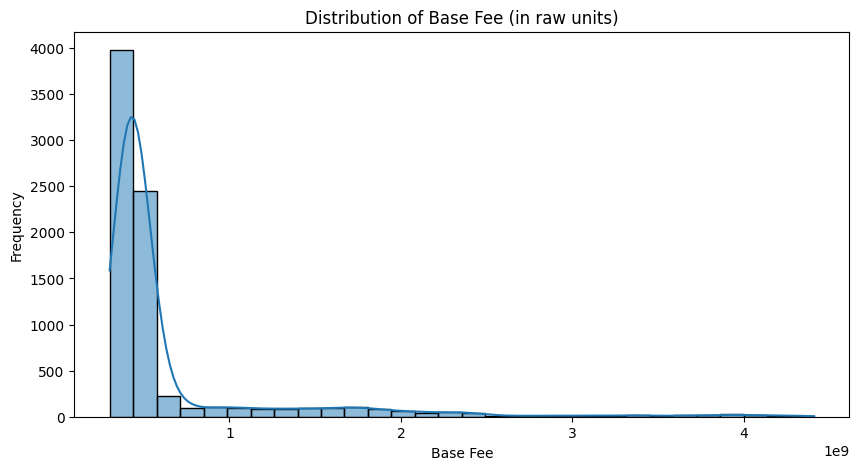

In [6]:
blocks_pd = df_blocks.to_pandas()
plt.figure(figsize=(10, 5))
sns.histplot(blocks_pd["base_fee"], bins=30, kde=True)
plt.title("Distribution of Base Fee (in raw units)")
plt.xlabel("Base Fee")
plt.ylabel("Frequency")
plt.show()

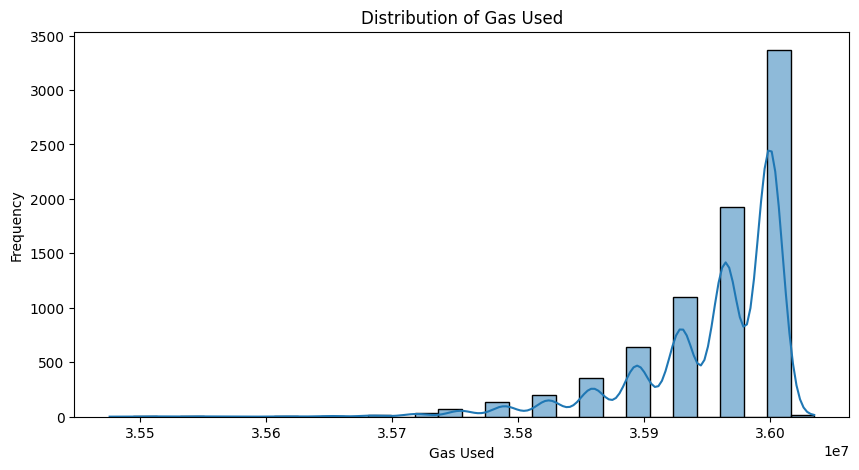

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(blocks_pd["gas_used"], bins=30, kde=True)
plt.title("Distribution of Gas Used")
plt.xlabel("Gas Used")
plt.ylabel("Frequency")
plt.show()

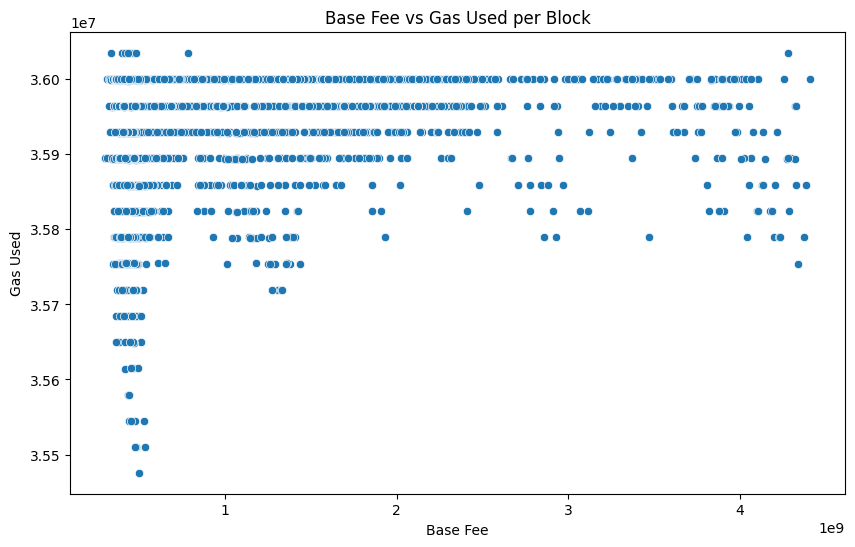

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="base_fee", y="gas_used", data=blocks_pd)
plt.title("Base Fee vs Gas Used per Block")
plt.xlabel("Base Fee")
plt.ylabel("Gas Used")
plt.show()

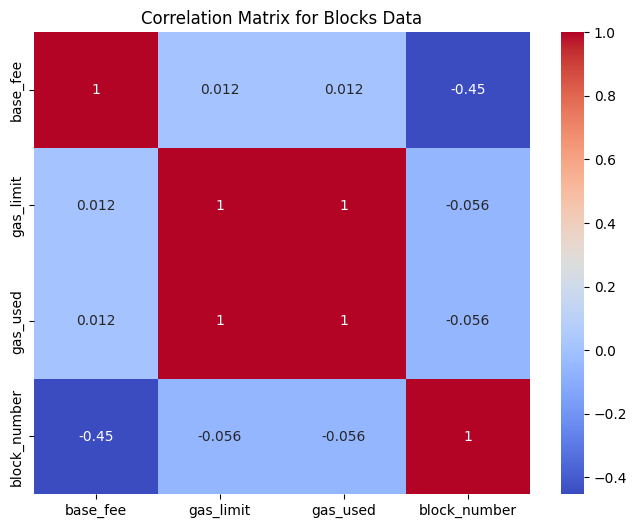

In [15]:
blocks_corr = blocks_pd[["base_fee", "gas_limit", "gas_used", "block_number"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(blocks_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Blocks Data")
plt.show()

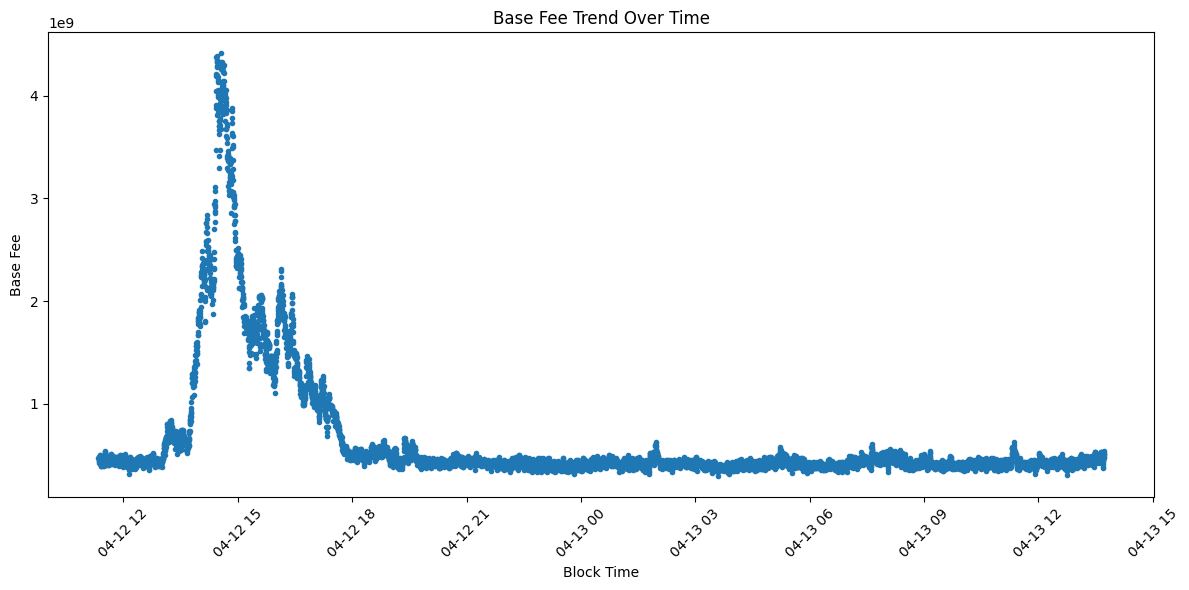

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(blocks_pd["block_time"], blocks_pd["base_fee"], marker=".", linestyle="-")
plt.title("Base Fee Trend Over Time")
plt.xlabel("Block Time")
plt.ylabel("Base Fee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Blocks Preprocessing

In [23]:
blocks_pd_clean = blocks_pd.drop(columns=["block_number"])

In [25]:
numeric_cols = ["base_fee", "gas_limit", "gas_used"]
blocks_df_numeric = blocks_pd_clean[numeric_cols]

In [26]:
scaler = RobustScaler()
scaled_array = scaler.fit_transform(blocks_df_numeric)
scaled_df_pd = pd.DataFrame(scaled_array, columns=numeric_cols)

In [27]:
df_numeric_scaled = pl.from_pandas(scaled_df_pd)
non_numeric_cols = [col for col in blocks_pd_clean.columns if col not in numeric_cols]
df_non_numeric = blocks_pd_clean[non_numeric_cols]

In [29]:
final_df = pd.concat([scaled_df_pd, df_non_numeric], axis=1)
final_df.head()

,base_fee,gas_limit,gas_used,block_hash,block_time
0,6.228737,-0.998024,-0.998024,0x6588a8a373743c33445550e53c7e412ee6195ee40641...,2025-04-12 17:04:23
1,1.956486,0.498287,0.498287,0x4fcef8d350f3b815583dd49cae0a4e6229ebb080c4a6...,2025-04-12 19:21:23
2,20.896852,0.498756,0.498756,0x280b2f703c8d3531165f9a208f9f7396a94bd3889b54...,2025-04-12 14:14:59
3,-0.186692,-0.003909,-0.003909,0xa096ba13316b31f9404b180a836f52a3a89c3304d3be...,2025-04-12 21:53:35
4,-0.599029,-0.499254,-0.499254,0x11c8cd222dd8db27bdef6a69ceb11d25f830922ae061...,2025-04-12 23:39:23


In [30]:
final_df.to_parquet("../data/interim/blocks_data.parquet", index=False)

#### Transactions

In [9]:
df_tx.describe()

statistic,tx_hash,cost,from,gas,gas_fee_cap,gas_price,tx_time,to,block_hash
str,str,f64,str,f64,f64,f64,str,str,str
"""count""","""1753000""",1.753e6,"""1753000""",1.753e6,1.753e6,1.753e6,"""1753000""","""1753000""","""1753000"""
"""null_count""","""0""",0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0"""
"""mean""",null,0.882238,null,270355.830442,1.5855e10,1.5855e-8,"""2025-04-13 01:59:37.228570""",null,null
"""std""",null,63.409857,null,1.0955e6,7.7319e10,7.7319e-8,null,null,null
"""min""","""0x000003eac3896ae2727b9f105635…",0.000007,"""0x00000000000007736e2f9aa5630b…",21000.0,3.01863789e8,3.0186e-10,"""2025-04-12 11:20:47""","""0x""","""0x000098da11238e8388191fdaeadd…"
"""25%""",null,0.000128,null,21000.0,5.91692924e8,5.9169e-10,"""2025-04-12 19:17:47""",null,null
"""50%""",null,0.0005,null,84975.0,1.1815e9,1.1815e-9,"""2025-04-13 03:07:11""",null,null
"""75%""",null,0.018174,null,221994.0,2.5428e9,2.5428e-9,"""2025-04-13 08:36:23""",null,null
"""max""","""0xfffff877120338efc04d416dc697…",29456.368576,"""0xffffffff7a5cb56bbccb9dfaff17…",3.416657e7,3.0895e13,0.000031,"""2025-04-13 13:43:23""","""0xfffffffff15abf397da76f1dcc1a…","""0xfffe304e5a5339fb1bd6397a133c…"


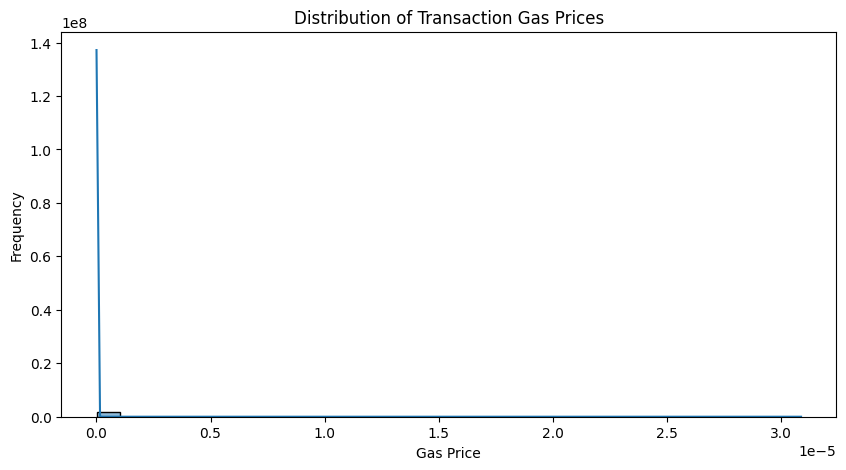

In [10]:
tx_pd = df_tx.to_pandas()
plt.figure(figsize=(10, 5))
sns.histplot(tx_pd["gas_price"], bins=30, kde=True)
plt.title("Distribution of Transaction Gas Prices")
plt.xlabel("Gas Price")
plt.ylabel("Frequency")
plt.show()

Some outlier action is taking place but we are not sure if we can remove this, as it is probably the most significant moments to predict 😅

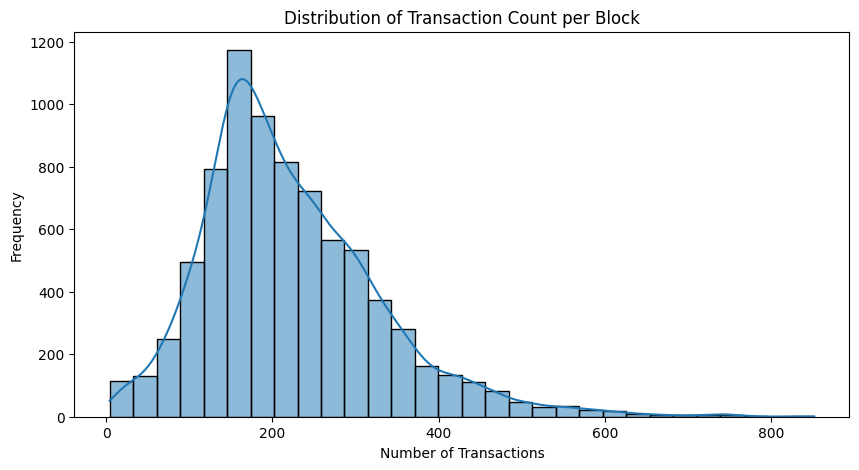

In [13]:
tx_count_by_block = tx_pd.groupby("block_hash")["tx_hash"].count().reset_index(name="tx_count")
plt.figure(figsize=(10, 5))
sns.histplot(tx_count_by_block["tx_count"], bins=30, kde=True)
plt.title("Distribution of Transaction Count per Block")
plt.xlabel("Number of Transactions")
plt.ylabel("Frequency")
plt.show()

In [17]:
avg_tx_gas = df_tx.group_by("block_hash").agg(pl.col("gas_price").mean().alias("avg_tx_gas_price"))
blocks_tx_join = df_blocks.join(avg_tx_gas, on="block_hash")
blocks_tx_pd = blocks_tx_join.to_pandas()

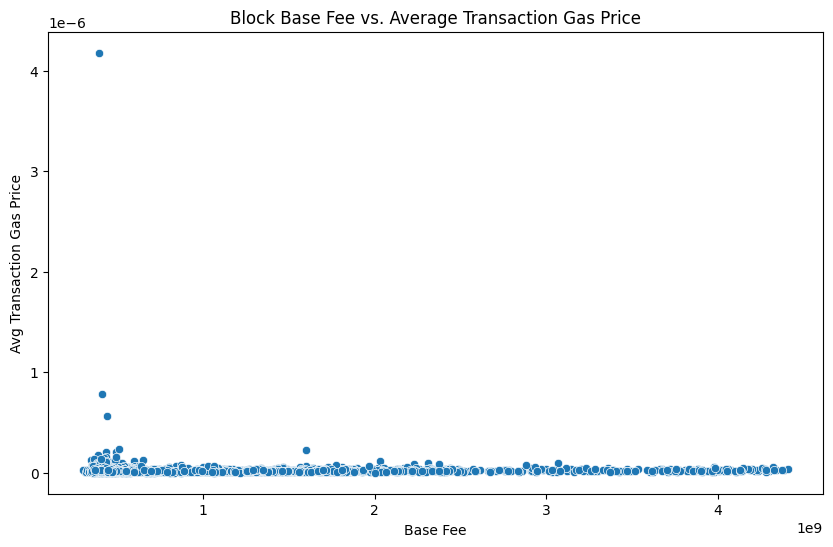

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="base_fee", y="avg_tx_gas_price", data=blocks_tx_pd)
plt.title("Block Base Fee vs. Average Transaction Gas Price")
plt.xlabel("Base Fee")
plt.ylabel("Avg Transaction Gas Price")
plt.show()

#### Transactions Preprocessing

In [31]:
tx_clean = tx_pd.drop(columns=["tx_hash", "from", "to"])

In [32]:
numeric_cols = ["cost", "gas", "gas_fee_cap", "gas_price"]
tx_numeric = tx_clean[numeric_cols]
non_numeric_cols = [col for col in tx_clean.columns if col not in numeric_cols]
tx_non_numeric = tx_clean[non_numeric_cols]

In [33]:
tx_numeric = tx_numeric.astype(float)

In [34]:
scaler_tx = RobustScaler()
tx_scaled_array = scaler_tx.fit_transform(tx_numeric)
scaled_tx_pd = pd.DataFrame(tx_scaled_array, columns=numeric_cols)

In [36]:
with open("tx_scaler.pkl", "wb") as f:
    pickle.dump(scaler_tx, f)

In [38]:
tx_final = pd.concat([scaled_tx_pd, tx_non_numeric], axis=1)

In [40]:
tx_final.to_parquet("../data/interim/tx_data.parquet", index=False)

#### ETH/USDT

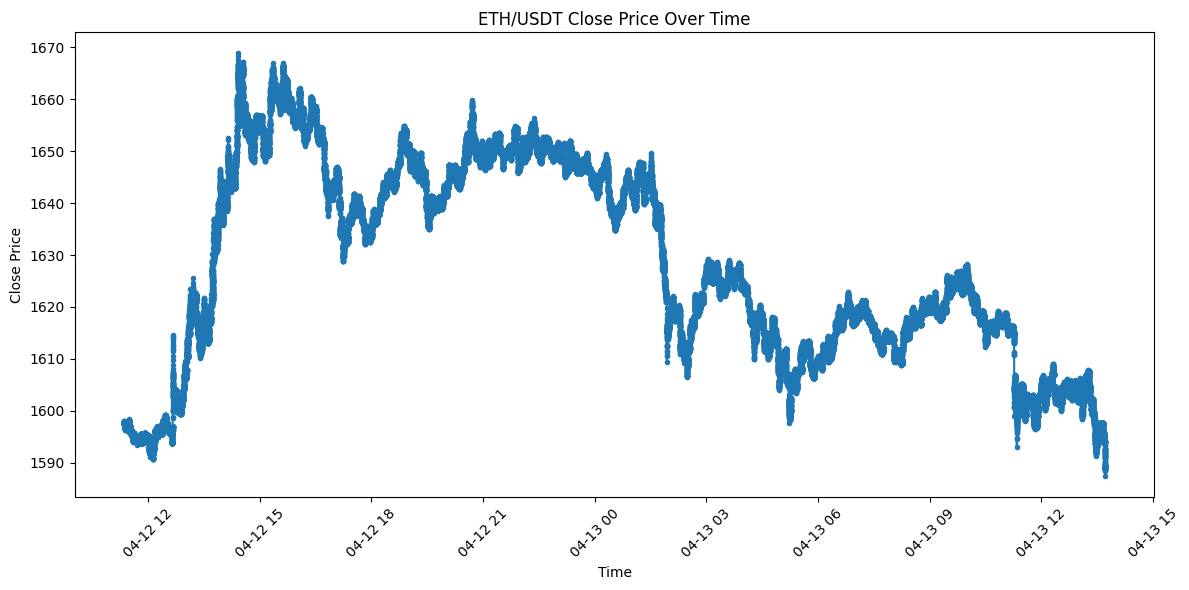

In [10]:
ticks_pd = df_ticks.to_pandas()
plt.figure(figsize=(12, 6))
plt.plot(ticks_pd["open_time"], ticks_pd["close"], marker=".", linestyle="-")
plt.title("ETH/USDT Close Price Over Time")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### ETH/USDT Prediction

In [11]:
df_ticks_clean = df_ticks.drop(["taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"])

In [12]:
numeric_cols = ["open", "high", "low", "close", "volume", "quote_asset_volume", "number_of_trades"]
non_numeric_cols = [col for col in df_ticks_clean.columns if col not in numeric_cols]

df_numeric = df_ticks_clean.select(numeric_cols)
df_numeric_pd = df_numeric.to_pandas().astype(float)

In [13]:
scaler_ticks = RobustScaler()
scaled_array = scaler_ticks.fit_transform(df_numeric_pd)
scaled_numeric_pd = pd.DataFrame(scaled_array, columns=numeric_cols)

In [14]:
df_numeric_scaled = pl.from_pandas(scaled_numeric_pd)
df_non_numeric = df_ticks_clean.select(non_numeric_cols)
df_ticks_final = df_non_numeric.hstack(df_numeric_scaled)

In [15]:
df_ticks_final.write_parquet("../data/interim/ticks_data.parquet")

## Final Dataset

Just merging features...

In [16]:
df_ticks = pd.read_parquet("../data/interim/ticks_data.parquet")
df_blocks = pd.read_parquet("../data/interim/blocks_data.parquet")
df_tx = pd.read_parquet("../data/interim/tx_data.parquet")

In [17]:
df_blocks["block_hash"] = df_blocks["block_hash"].astype(str)
df_tx["block_hash"] = df_tx["block_hash"].astype(str)

df_full = df_tx.merge(df_blocks, on="block_hash", how="left")

In [18]:
df_full.sample(2)

,cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time
769109,169.943979,-0.174010,2.708605,2.708605,2025-04-12 14:47:11,0xbfa39e6de68a5cc3fee2c1ba2f50507e8dbeffe3bc85...,32.566674,0.499751,0.499751,2025-04-12 14:47:11
1476296,0.829429,-0.318293,-0.305333,-0.305333,2025-04-13 11:02:35,0xbf9d146e6e660a359e7e1445b080893b86cff11ee521...,-0.426314,-0.002900,-0.002900,2025-04-13 11:02:35


In [19]:
df_full.to_parquet("../data/processed/tx_blocks.parquet")

In [23]:
df_full["tx_second"] = df_full["tx_time"].dt.floor("S")
df_ticks["tick_second"] = df_ticks["open_time"].dt.floor("S")

In [24]:
df_full_ticks = df_full.merge(df_ticks, left_on="tx_second", right_on="tick_second", how="left")
df_full_ticks = df_full_ticks.drop(columns=["tx_second", "tick_second"])

In [25]:
df_full_ticks.shape

(1753000, 21)

In [26]:
df_full_ticks.head()

,cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,...,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,tick_minute
0,-0.009676,1.437680,-0.159582,-0.159582,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,...,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047,2025-04-13 13:22:00
1,-0.021672,-0.151875,0.419496,0.419496,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,...,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047,2025-04-13 13:22:00
2,5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,...,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047,2025-04-13 13:22:00
3,5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,...,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047,2025-04-13 13:22:00
4,0.026129,0.461073,2.197437,2.197437,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,...,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047,2025-04-13 13:22:00


In [27]:
df_full_ticks = df_full_ticks.drop(columns=["tx_minute", "tick_minute"])

In [28]:
df_full_ticks.to_parquet("../data/processed/tx_blocks_eth.parquet")

### Validating

We need to get rid of null values since NN do not support them

In [2]:
df_full_ticks = pl.read_parquet("../data/processed/tx_blocks_eth.parquet")

In [3]:
df_full_ticks.null_count()

cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,94460,94460,94460,94460,94460,94460,94460,94460,380635


In [4]:
cols_to_check = ["open_time", "close_time", "open", "high", "low", "close", "volume"]

condition = pl.fold(
    acc=pl.lit(True),
    function=lambda acc, col: acc & col.is_null(),
    exprs=[pl.col(col) for col in cols_to_check],
)

In [6]:
df_nulls = df_full_ticks.filter(condition)

In [9]:
df_nulls_pd = df_nulls.to_pandas()

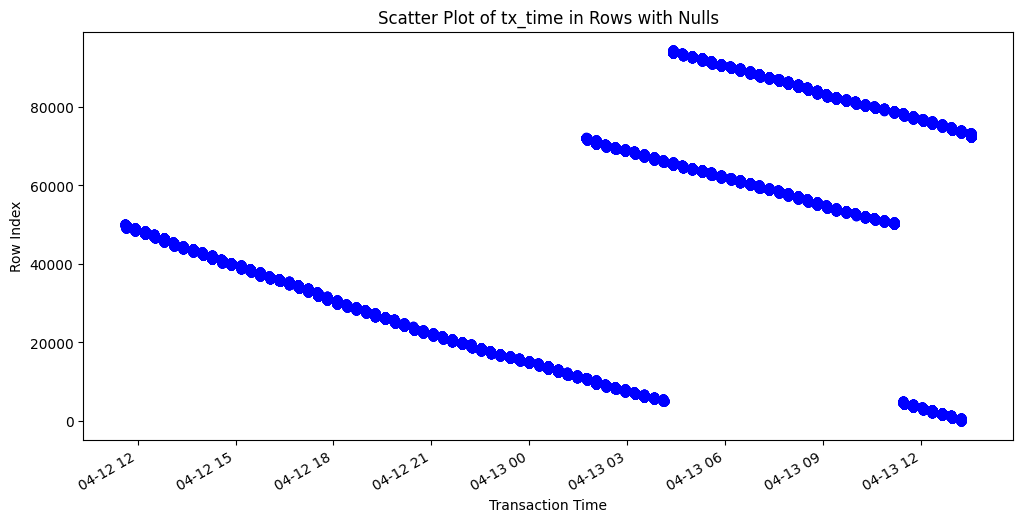

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(df_nulls_pd["tx_time"], df_nulls_pd.index, marker="o", color="blue", alpha=0.6)
plt.xlabel("Transaction Time")
plt.ylabel("Row Index")
plt.title("Scatter Plot of tx_time in Rows with Nulls")
plt.gcf().autofmt_xdate()  # Auto-format the x-axis labels for dates
plt.show()

**Probably some stock issues, we can remove them**

In [11]:
df_clean = df_full_ticks.drop_nulls(subset=cols_to_check)

In [12]:
df_clean.null_count()

cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,286175


**No trades were done, so the count is 0**

In [13]:
df_clean = df_clean.fill_null(0.0)

In [14]:
df_clean.null_count()

cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df_clean.write_parquet("../data/processed/tx_blocks_eth_clean.parquet")

## Conclusion

- Collected a ~1.7 billion large dataset
- 13 features and gas_price as target
- Scaled the features for NNs
- Ready for action 😎